In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from PIL import Image
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn. metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("user_behavior_dataset.csv")   # https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset

df['User Behavior Class'] = LabelEncoder().fit_transform(df['User Behavior Class'])
df["Device Model"] = LabelEncoder().fit_transform(df["Device Model"])
df["Operating System"] = LabelEncoder().fit_transform(df["Operating System"])
df["Gender"] = LabelEncoder().fit_transform(df["Gender"])
df[list(df)[:-1]] = StandardScaler().fit_transform(df[list(df)[:-1]])

X = df.drop('User Behavior Class', axis = 1)
y = df['User Behavior Class']

df.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,-1.729578,-1.420106,-0.513359,0.688256,0.367626,0.423726,0.606096,0.300405,0.126383,0.960769,3
1,-1.724629,-0.720547,-0.513359,-0.017668,-0.186771,-0.237198,-0.322441,0.022277,0.709506,-1.040833,2
2,-1.719681,0.678573,-0.513359,-0.661471,-0.415053,-0.933550,-0.693856,-0.949607,0.292989,0.960769,1
3,-1.714732,-1.420106,-0.513359,-0.181443,-0.154160,0.184279,0.197540,-0.091787,-1.539682,0.960769,2
4,-1.709783,1.378133,1.947953,-0.475107,-0.317218,-0.193218,0.271823,0.091028,-0.623346,-1.040833,2


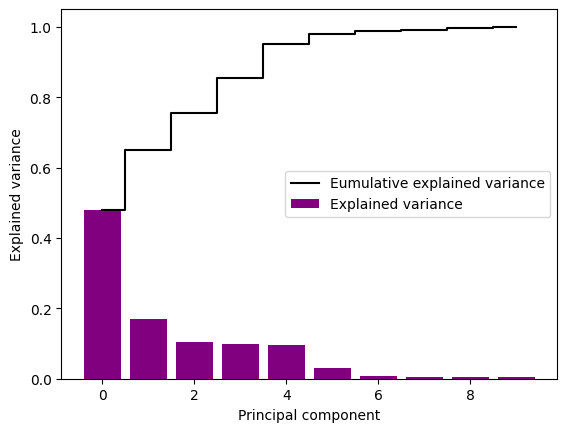

In [2]:
# 1. Зниження розмірності і візуалізація даних

pca = PCA()
X_pca = pca.fit_transform(X)

exp_var = pca.explained_variance_ratio_
cum_sum = np.cumsum(exp_var)

plt.bar(range(0, len(exp_var)), exp_var, label='Explained variance', color = 'purple')
plt.step(range(0, len(cum_sum)), cum_sum, where='mid', label='Eumulative explained variance', color = 'black')
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.legend()
plt.show()

,pca_1,pca_2,User Behavior Class
0,1.045930,-1.456880,3
1,-0.344779,-0.773473,2
2,-1.603124,0.118316,1
3,-0.046969,-1.474135,2
4,-0.187138,2.396439,2


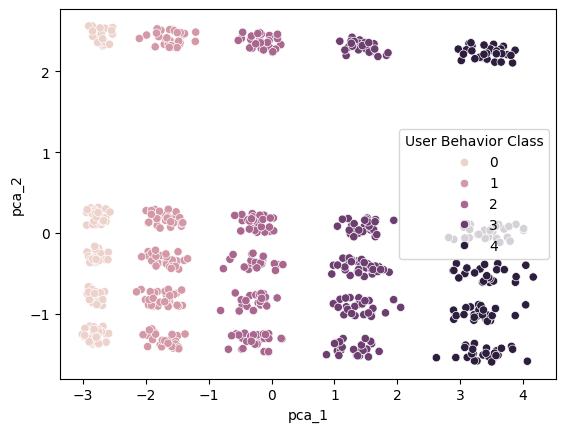

In [3]:
pca = PCA(n_components=2)
X2_pca  = pca.fit_transform(X)

X2_pca_df = pd.DataFrame({'pca_1': X2_pca[:,0], 'pca_2': X2_pca[:,1], 'User Behavior Class': y})
sns.scatterplot(x='pca_1', y='pca_2', hue='User Behavior Class', data=X2_pca_df)

X2_pca_df.head(5)

,tsne_1,tsne_2,User Behavior Class
0,14.757749,-12.133044,3
1,-16.282909,-3.501665,2
2,-11.250107,-28.410347,1
3,0.312277,-18.712128,2
4,4.565731,41.066124,2


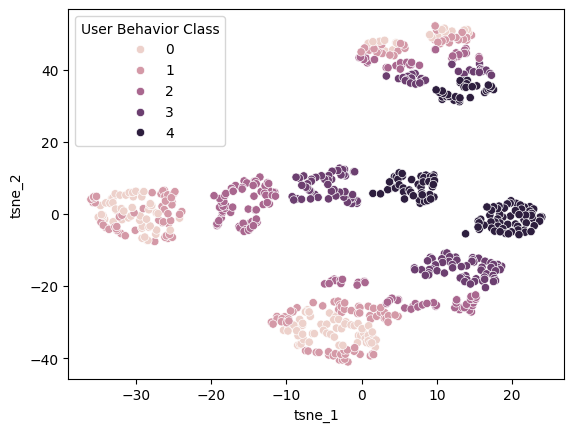

In [4]:
tsne = TSNE(n_components=2)
X2_tsne  = tsne.fit_transform(X)

X2_tsne_df = pd.DataFrame({'tsne_1': X2_tsne[:,0], 'tsne_2': X2_tsne[:,1], 'User Behavior Class': y})
sns.scatterplot(x='tsne_1', y='tsne_2', hue='User Behavior Class', data=X2_tsne_df)

X2_tsne_df.head(5)

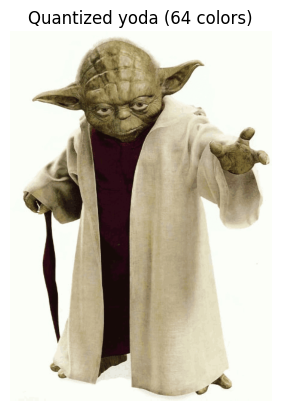

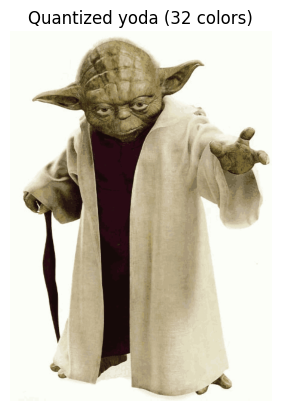

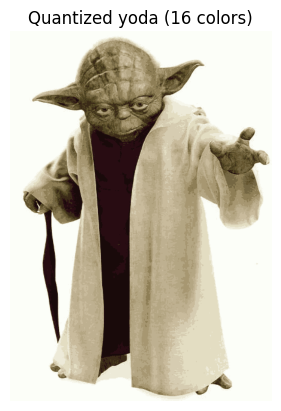

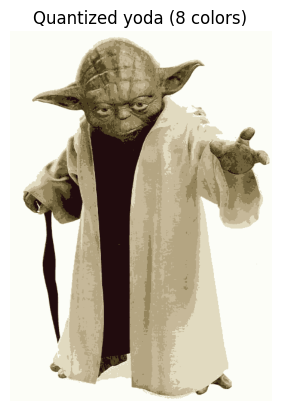

In [5]:
# 2. Кластерний аналіз

n_colors = [64, 32, 16, 8]
image = np.array(Image.open('yoda.jpg'), dtype=np.float64) / 255

w, h, d = tuple(image.shape)
image_array = np.reshape(image, (w * h, d))

for i in range(len(n_colors)):
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=n_colors[i], random_state=0).fit(image_array_sample)
    label = kmeans.predict(image_array)
    plt.figure()
    plt.axis("off")
    plt.title(f"Quantized yoda ({n_colors[i]} colors)")
    plt.imshow(kmeans.cluster_centers_[label].reshape(w, h, -1))

In [6]:
# 3. Обробка та класифікація текстових даних

df_spam = pd.read_csv('spam.csv') # https://www.kaggle.com/datasets/mariumfaheem666/spam-sms-classification-using-nlp

df_spam.dropna(inplace = True)
df_spam['Class'] = LabelEncoder().fit_transform(df_spam['Class'])

df_spam.head(10)

,Class,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [11]:
# data preprocessing

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

def clean(text):
    text = text.lower()
    text = re.sub("https*\S+|www.\S+", " ", text)
    text = re.sub("@\S+|#\S+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"\d+", " ", text)
    stop_words = set(stopwords.words("english"))
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    lemmatizer = WordNetLemmatizer()
    text = " ".join(lemmatizer.lemmatize(word) for word in text.split())
    return text

df_spam['Message'] = df_spam['Message'].apply(clean)
df_spam.head(10)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\111\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\111\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Class,Message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor u c already say
4,0,nah dont think go usf life around though
5,1,freemsg hey darling week word back id like fun...
6,0,even brother like speak treat like aid patent
7,0,per request melle melle oru minnaminunginte nu...
8,1,winner valued network customer selected receiv...
9,1,mobile month u r entitled update latest colour...


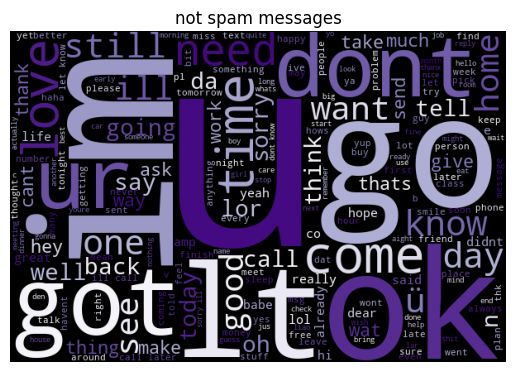

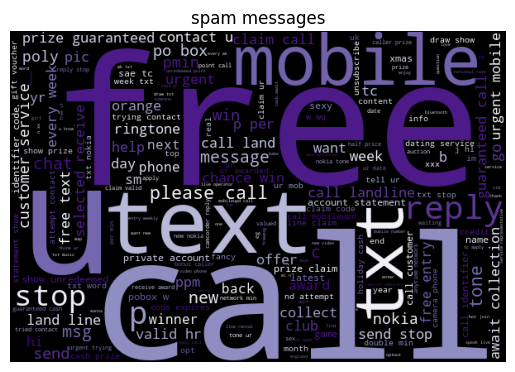

In [14]:
# data visualization

for i in [0, 1]:
    text = ''
    for msg in df_spam[df_spam['Class'] == i]['Message']:
        text += msg + ' '
    wordcloud = WordCloud(width=600, height=400, background_color="black", colormap='Purples_r').generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('spam messages') if i else plt.title('not spam messages')
    plt.show()

In [15]:
# text vectorization and train/test split
 
X = df_spam['Message']
y = df_spam['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

cv = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_vectorised = cv.fit_transform(X_train)
X_test_vectorised = cv.transform(X_test)

logreg_model = LogisticRegression()
logreg_model.fit(X_train_vectorised, y_train)
y_pred = logreg_model.predict(X_test_vectorised)

print('*Logistic Regression*\n')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

*Logistic Regression*

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       968
           1       1.00      0.82      0.90       147

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115

[[968   0]
 [ 27 120]]


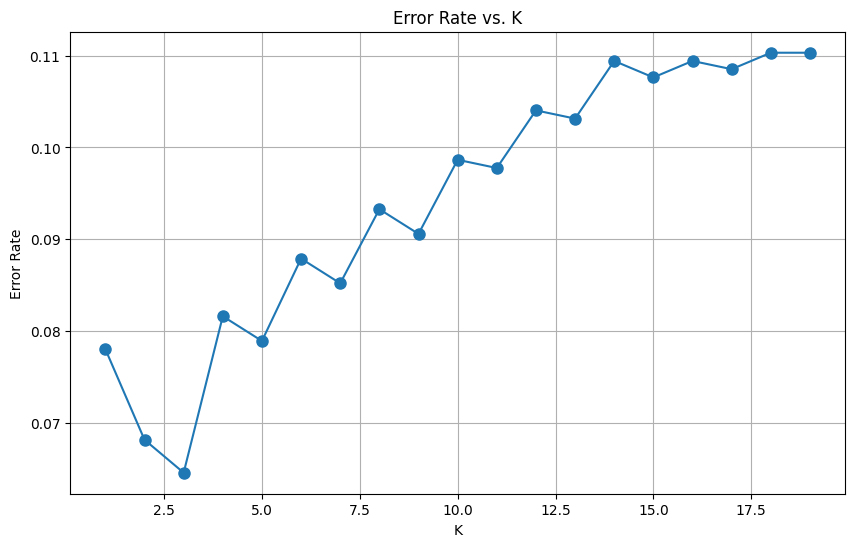

In [28]:
error_rate = []

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_vectorised,y_train)
    pred_i = knn.predict(X_test_vectorised)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,20), error_rate, marker='o', markersize=8)
plt.title('Error Rate vs. K')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid()

In [24]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_vectorised, y_train)
y_pred = knn_model.predict(X_test_vectorised)

print('*KNN*\n')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

*KNN*

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       968
           1       0.99      0.52      0.68       147

    accuracy                           0.94      1115
   macro avg       0.96      0.76      0.82      1115
weighted avg       0.94      0.94      0.93      1115

[[967   1]
 [ 71  76]]


In [25]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_vectorised, y_train)
y_pred = tree_model.predict(X_test_vectorised)

print('*Decision Tree*\n')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

*Decision Tree*

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       968
           1       0.89      0.86      0.87       147

    accuracy                           0.97      1115
   macro avg       0.93      0.92      0.93      1115
weighted avg       0.97      0.97      0.97      1115

[[952  16]
 [ 21 126]]


In [26]:
svc_model = SVC()
svc_model.fit(X_train_vectorised, y_train)
y_pred = svc_model.predict(X_test_vectorised)

print('*SVC*\n')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

*SVC*

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       968
           1       1.00      0.82      0.90       147

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115

[[968   0]
 [ 27 120]]
